Iñigo Martin Melero

## Participante 8

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_8_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


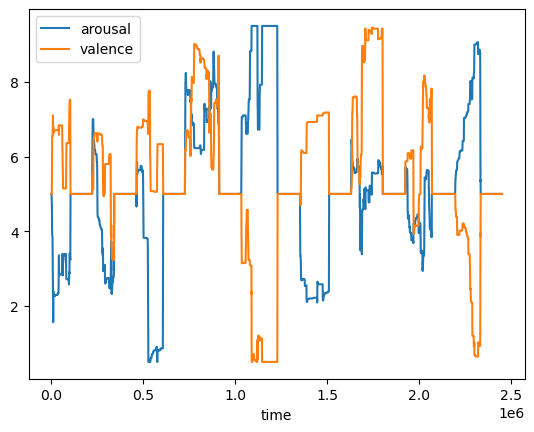

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_8_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  1.313  36.545  27.425  38.006  25.579    26.922     8.193   
1              1  1.293  36.603  27.417  37.948  25.561    26.512     8.151   
2              2  1.273  36.661  27.409  37.890  25.544    26.101     8.110   
3              3  1.254  36.719  27.401  37.832  25.526    25.691     8.069   
4              4  1.234  36.777  27.393  37.774  25.509    25.280     8.028   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.764  37.290  33.591  37.599  32.583    10.451     9.423   
2451580  2451580  0.748  37.396  33.568  37.571  32.594    10.410     9.383   
2451581  2451581  0.747  37.187  33.579  37.561  32.590    10.328     9.423   
2451582  2451582  0.754  37.108  33.603  37.561  32.597    10.246     9.464   
2451583  2451583  0.767  37.241  33.572  37.561  32.597    10.245     9.424   

         emg_trap  video  
0          16.530     10

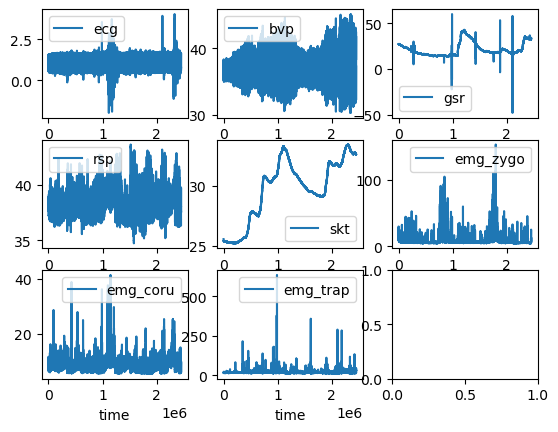

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

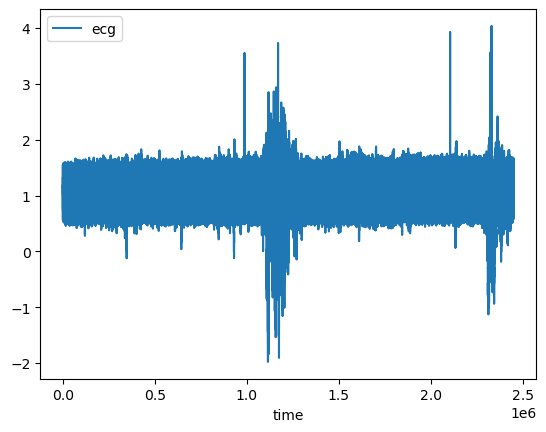

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

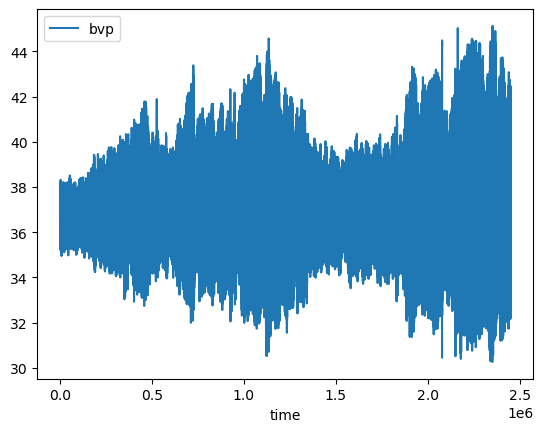

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

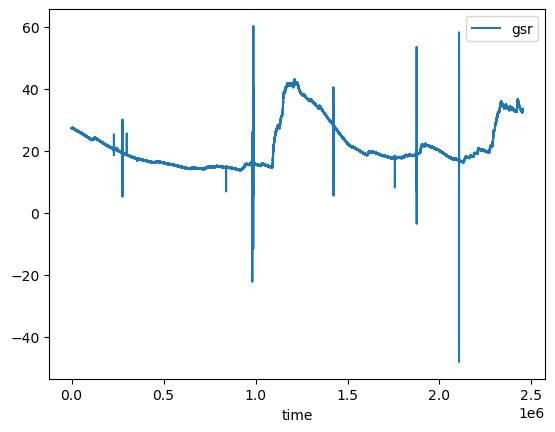

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

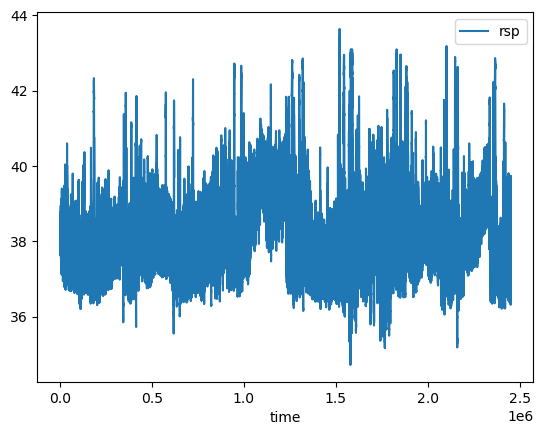

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

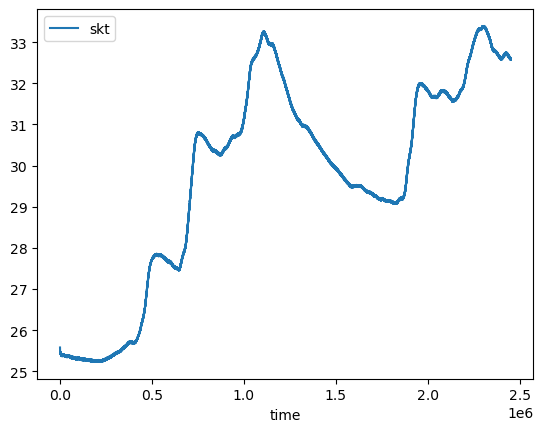

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

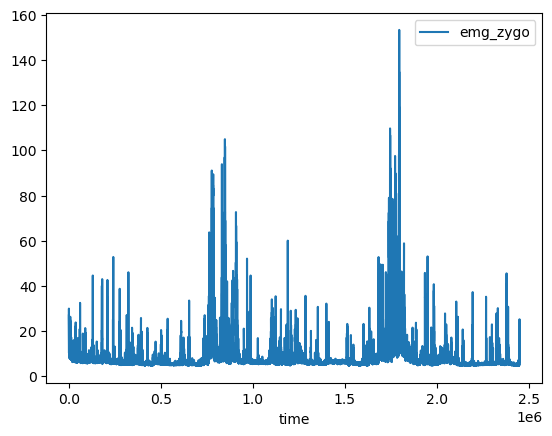

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

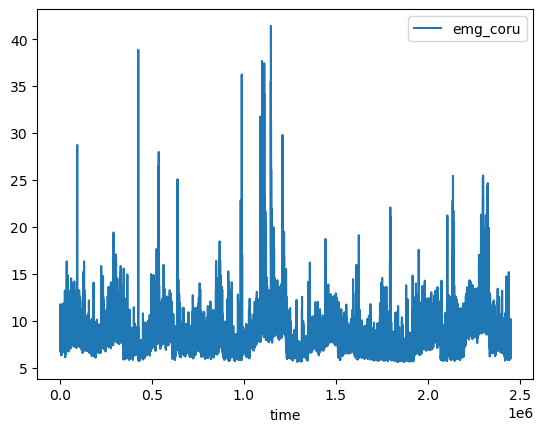

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

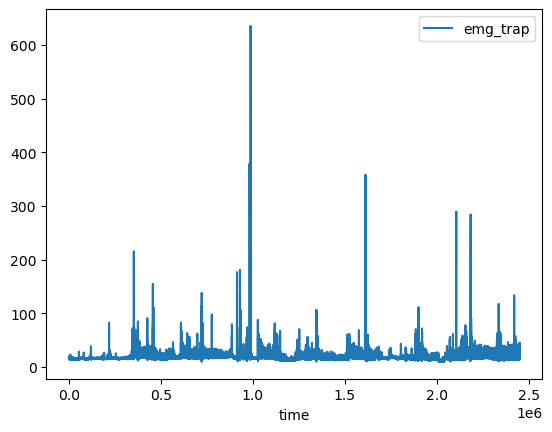

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

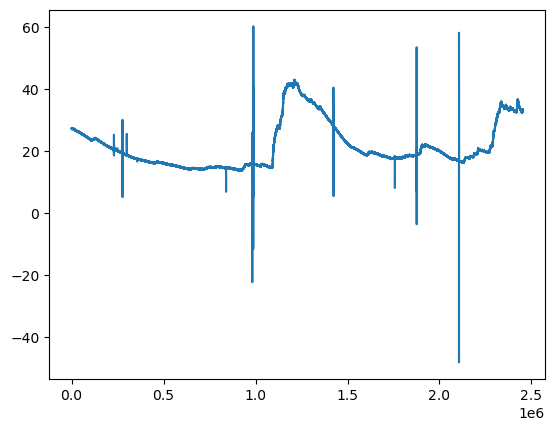

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

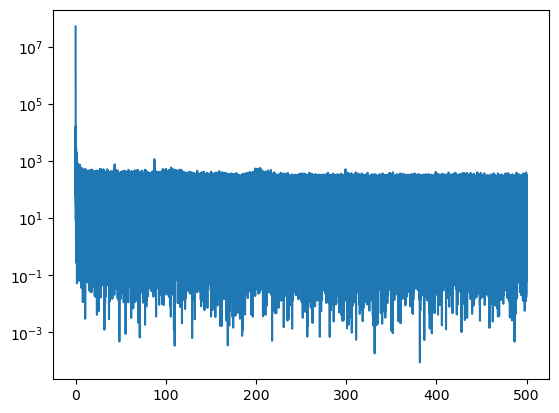

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

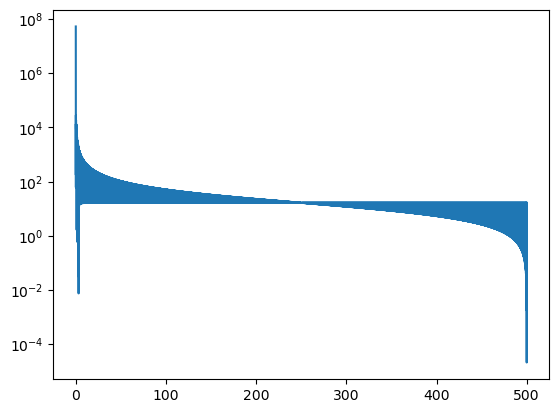

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

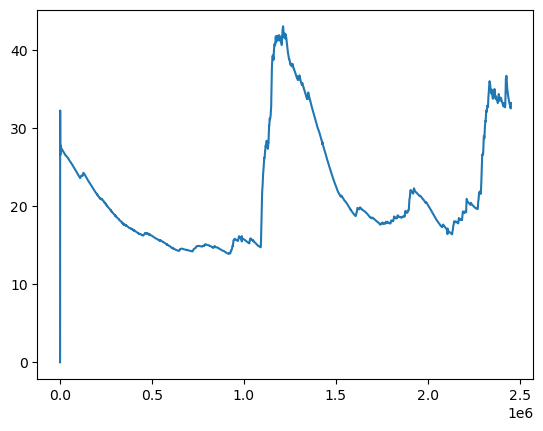

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  33.174
2451580  33.175
2451581  33.176
2451582  33.177
2451583  33.178

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

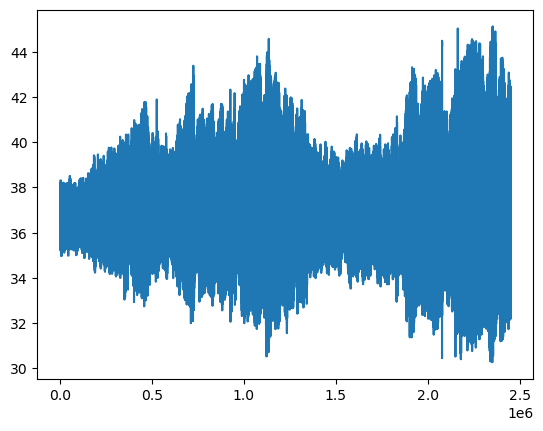

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

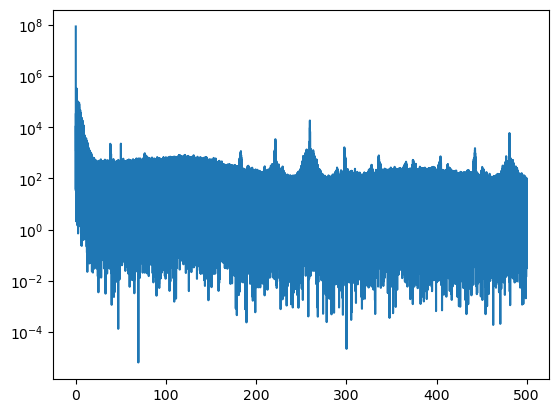

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

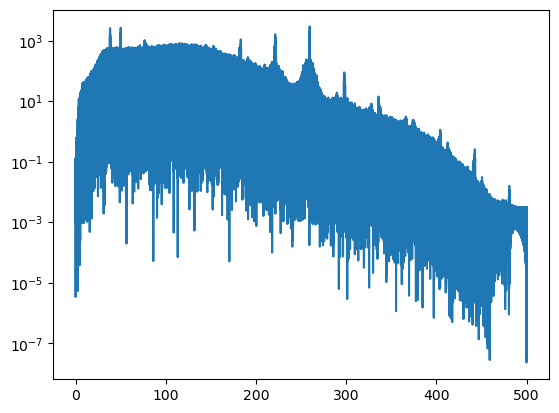

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

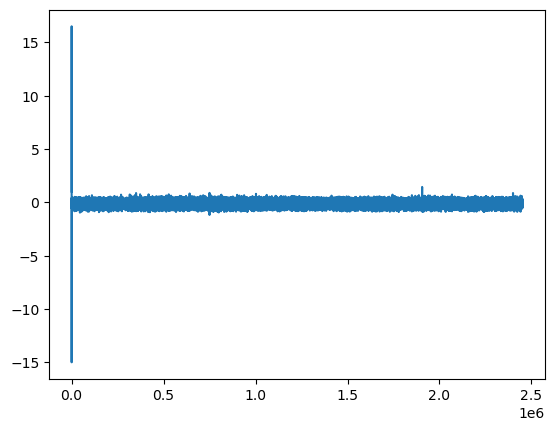

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.015
1        42.667
2        50.339
3        53.512
4        46.276
...         ...
2451579  37.000
2451580  37.221
2451581  37.257
2451582  37.174
2451583  37.061

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

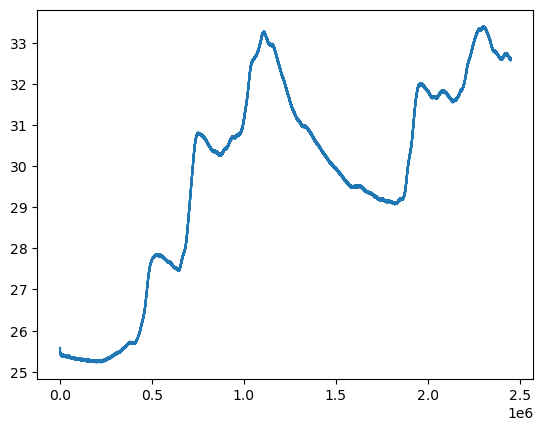

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

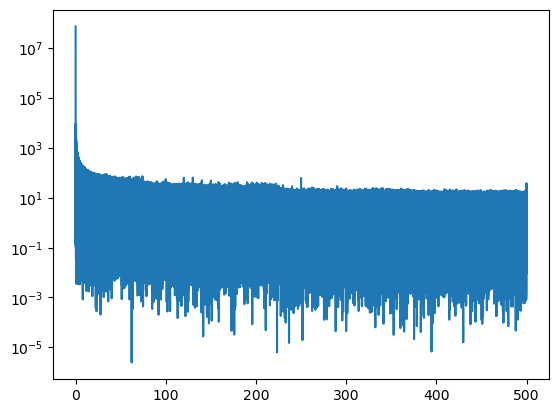

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

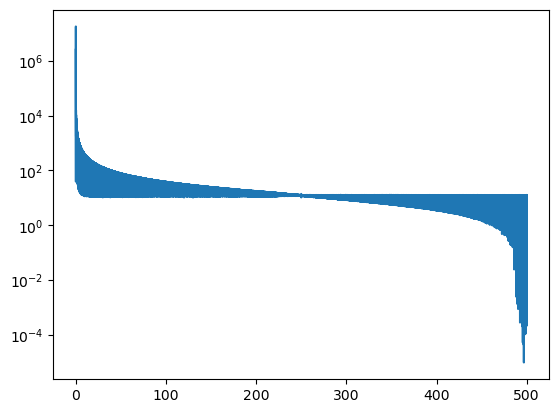

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

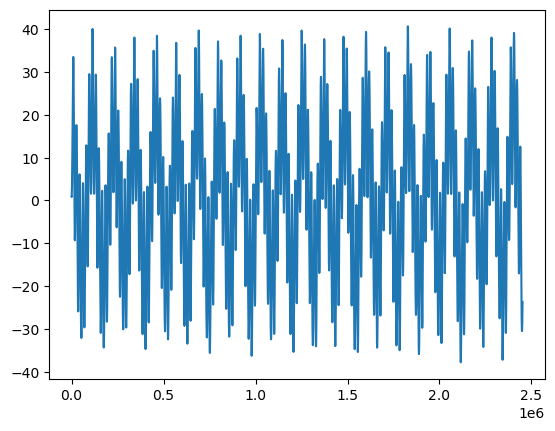

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.820
1        40.819
2        40.819
3        40.818
4        40.817
...         ...
2451579  16.246
2451580  16.251
2451581  16.255
2451582  16.259
2451583  16.263

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  1.313  38.006    26.922     8.193    16.530     10
1              1  1.293  37.948    26.512     8.151    16.406     10
2              2  1.273  37.890    26.101     8.110    16.283     10
3              3  1.254  37.832    25.691     8.069    16.160     10
4              4  1.234  37.774    25.280     8.028    16.037     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.764  37.599    10.451     9.423    33.159     12
2451580  2451580  0.748  37.571    10.410     9.383    33.283     12
2451581  2451581  0.747  37.561    10.328     9.423    33.122     12
2451582  2451582  0.754  37.561    10.246     9.464    32.754     12
2451583  2451583  0.767  37.561    10.245     9.424    32.262     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  1.313  38.006    26.922     8.193    16.530     10  38.015   
1              1  1.293  37.948    26.512     8.151    16.406     10  42.667   
2              2  1.273  37.890    26.101     8.110    16.283     10  50.339   
3              3  1.254  37.832    25.691     8.069    16.160     10  53.512   
4              4  1.234  37.774    25.280     8.028    16.037     10  46.276   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.764  37.599    10.451     9.423    33.159     12  37.000   
2451580  2451580  0.748  37.571    10.410     9.383    33.283     12  37.221   
2451581  2451581  0.747  37.561    10.328     9.423    33.122     12  37.257   
2451582  2451582  0.754  37.561    10.246     9.464    32.754     12  37.174   
2451583  2451583  0.767  37.561    10.245     9.424    32.262     12  37.061   

            gsr     skt  
0         0.000  40.820  
1         0.000  40.819  
2         0.000  40.819  
3         0.000  40.818  
4         0.000  40.817  
...         ...     ...  
2451579  33.174  16.246  
2451580  33.175  16.251  
2451581  33.176  16.255  
2451582  33.177  16.259  
2451583  33.178  16.263  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.525353  0.565910  0.238765  0.772915  0.296989  0.011595   
221502    221502  0.529676  0.577016  0.238765  0.772836  0.295704  0.012147   
221503    221503  0.527515  0.574119  0.238765  0.772770  0.295562  0.011878   
221504    221504  0.529676  0.552390  0.238765  0.772691  0.298416  0.012423   
221505    221505  0.531338  0.540802  0.238765  0.772625  0.298416  0.012154   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.917041  0.607919  0.715883  0.346260  0.522192  0.007732   
2331580  2331580  0.913217  0.580879  0.715918  0.346339  0.524904  0.007732   
2331581  2331581  0.913217  0.583293  0.715918  0.346418  0.524904  0.007187   
2331582  2331582  0.916376  0.587156  0.715952  0.346497  0.524904  0.007450   
2331583  2331583  0.924023  0.550942  0.715952  0.346576  0.531754  0.008547   

         emg_coru  emg_trap  video  
221501   0.041342  0.100345      3  
221502   0.041342  0.098490      3  
221503   0.042490  0.097087      3  
221504   0.042490  0.095696      3  
221505   0.042490  0.093841      3  
...           ...       ...    ...  
2331579  0.183816  0.101273      8  
2331580  0.186167  0.099417      8  
2331581  0.188462  0.098015      8  
2331582  0.196440  0.097087      8  
2331583  0.199938  0.095696      8  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.525353  0.565910  0.238765  0.296989  0.772915  0.011595   
221502    221502  0.529676  0.577016  0.238765  0.295704  0.772836  0.012147   
221503    221503  0.527515  0.574119  0.238765  0.295562  0.772770  0.011878   
221504    221504  0.529676  0.552390  0.238765  0.298416  0.772691  0.012423   
221505    221505  0.531338  0.540802  0.238765  0.298416  0.772625  0.012154   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.917041  0.607919  0.715883  0.522192  0.346260  0.007732   
2331580  2331580  0.913217  0.580879  0.715918  0.524904  0.346339  0.007732   
2331581  2331581  0.913217  0.583293  0.715918  0.524904  0.346418  0.007187   
2331582  2331582  0.916376  0.587156  0.715952  0.524904  0.346497  0.007450   
2331583  2331583  0.924023  0.550942  0.715952  0.531754  0.346576  0.008547   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.531338  0.522453  0.238731  0.298416  0.771517  0.012430  0.050523   
221540   0.525353  0.552390  0.238731  0.296989  0.770039  0.010774  0.047081   
221560   0.498088  0.545147  0.238765  0.288711  0.768562  0.009388  0.063147   
221580   0.472319  0.590536  0.238765  0.286000  0.767085  0.010209  0.057437   
221600   0.459850  0.549010  0.238800  0.281861  0.765607  0.009381  0.053966   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.908229  0.572187  0.714197  0.513772  0.339968  0.009388  0.201086   
2331520  0.915378  0.554804  0.714645  0.508349  0.341551  0.009125  0.195432   
2331540  0.915378  0.568324  0.715057  0.515199  0.343160  0.009381  0.161983   
2331560  0.911554  0.461130  0.715470  0.522192  0.344743  0.009112  0.158596   
2331580  0.913217  0.580879  0.715918  0.524904  0.346339  0.007732  0.186167   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.531338  0.522453  0.238731  0.298416  0.771517  0.012430  0.050523   
1      0.525353  0.552390  0.238731  0.296989  0.770039  0.010774  0.047081   
2      0.498088  0.545147  0.238765  0.288711  0.768562  0.009388  0.063147   
3      0.472319  0.590536  0.238765  0.286000  0.767085  0.010209  0.057437   
4      0.459850  0.549010  0.238800  0.281861  0.765607  0.009381  0.053966   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.908229  0.572187  0.714197  0.513772  0.339968  0.009388  0.201086   
63500  0.915378  0.554804  0.714645  0.508349  0.341551  0.009125  0.195432   
63501  0.915378  0.568324  0.715057  0.515199  0.343160  0.009381  0.161983   
63502  0.911554  0.461130  0.715470  0.522192  0.344743  0.009112  0.158596   
63503  0.913217  0.580879  0.715918  0.524904  0.346339  0.007732  0.186167   

       emg_trap  valence  arousal  
0      0.082688     5.00    5.000  
1      0.067338     5.00    5.000  
2      0.086387     5.00    5.000  
3      0.119360     5.00    5.000  
4      0.125909     5.00    5.000  
...         ...      ...      ...  
63499  0.134268     0.93    8.805  
63500  0.216956     0.93    8.805  
63501  0.212341     0.93    8.805  
63502  0.121713     0.93    8.805  
63503  0.099417     0.93    8.805  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.531338  0.522453  0.238731  0.298416  0.771517  0.012430  0.050523   
1      0.525353  0.552390  0.238731  0.296989  0.770039  0.010774  0.047081   
2      0.498088  0.545147  0.238765  0.288711  0.768562  0.009388  0.063147   
3      0.472319  0.590536  0.238765  0.286000  0.767085  0.010209  0.057437   
4      0.459850  0.549010  0.238800  0.281861  0.765607  0.009381  0.053966   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.948130  0.551424  0.712511  0.505637  0.333558  0.008015  0.198903   
63496  0.948130  0.553839  0.712924  0.501499  0.335154  0.008284  0.157476   
63497  0.945470  0.592950  0.713337  0.504210  0.336763  0.008836  0.149415   
63498  0.918703  0.536939  0.713784  0.506922  0.338359  0.008829  0.133264   
63499  0.908229  0.572187  0.714197  0.513772  0.339968  0.009388  0.201086   

       emg_trap  valence  arousal  
0      0.082688     5.00    5.000  
1      0.067338     5.00    5.000  
2      0.086387     5.00    5.000  
3      0.119360     5.00    5.000  
4      0.125909     5.00    5.000  
...         ...      ...      ...  
63495  0.421254     0.93    8.805  
63496  0.200769     0.93    8.805  
63497  0.122165     0.93    8.805  
63498  0.143103     0.93    8.805  
63499  0.134268     0.93    8.805  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.531338  0.522453  0.238731  0.298416  0.771517  0.012430  0.050523   
 1   0.525353  0.552390  0.238731  0.296989  0.770039  0.010774  0.047081   
 2   0.498088  0.545147  0.238765  0.288711  0.768562  0.009388  0.063147   
 3   0.472319  0.590536  0.238765  0.286000  0.767085  0.010209  0.057437   
 4   0.459850  0.549010  0.238800  0.281861  0.765607  0.009381  0.053966   
 5   0.459352  0.549976  0.238834  0.280434  0.764117  0.008560  0.052819   
 6   0.462510  0.556253  0.238834  0.276295  0.762640  0.012430  0.044785   
 7   0.461513  0.582810  0.238869  0.265306  0.761149  0.015471  0.045933   
 8   0.464173  0.492999  0.238903  0.261167  0.759659  0.014913  0.049376   
 9   0.463175  0.576050  0.238937  0.259740  0.758168  0.014368  0.057437   
 10  0.460848  0.588605  0.238972  0.259740  0.756678  0.012706  0.068913   
 11  0.456525  0.595365  0.239006  0.262452  0.755187  0.016292  0.072384   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.531338  0.522453  0.238731  0.298416  0.771517  0.012430  0.050523   
1     0.438570  0.563496  0.239144  0.250036  0.734135  0.008836  0.044785   
2     0.447215  0.601159  0.238731  0.216926  0.696556  0.010767  0.081537   
3     0.465337  0.559633  0.239213  0.356358  0.660045  0.010216  0.085036   
4     0.465337  0.552873  0.239832  0.511203  0.625671  0.010767  0.113755   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.528180  0.630613  0.690042  0.596832  0.163165  0.030398  0.098752   
2536  0.490274  0.620473  0.692451  0.737691  0.191827  0.007180  0.152858   
2537  0.667332  0.597779  0.697234  0.683888  0.225199  0.006905  0.142501   
2538  0.806151  0.570739  0.702188  0.570572  0.262185  0.008008  0.181604   
2539  0.850374  0.577499  0.705939  0.520765  0.301479  0.008008  0.206852   

             8         9        10  ...       193       194       195  \
0     0.082688  0.525353  0.552390  ...  0.457190  0.588122  0.239144   
1     0.127278  0.435245  0.551907  ...  0.446218  0.586190  0.238731   
2     0.108240  0.448379  0.569290  ...  0.459850  0.542733  0.239178   
3     0.076636  0.466334  0.594399  ...  0.466833  0.535973  0.239832   
4     0.100764  0.461513  0.531144  ...  0.528678  0.600676  0.240107   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.078977  0.482294  0.516659  ...  0.481629  0.572670  0.692382   
2536  0.113749  0.483957  0.598262  ...  0.637905  0.572670  0.696993   
2537  0.130547  0.689277  0.571704  ...  0.932336  0.547562  0.702051   
2538  0.383768  0.831920  0.573153  ...  0.838903  0.556736  0.705767   
2539  0.132425  0.869992  0.551424  ...  0.908229  0.572187  0.714197   

           196       197       198       199       200  valence  arousal  
0     0.252747  0.735639  0.010781  0.055114  0.111928  5.00000  5.00000  
1     0.218210  0.698047  0.010222  0.057437  0.112856  5.00000  5.00000  
2     0.343942  0.661470  0.009119  0.087303  0.082213  5.00000  5.00000  
3     0.505637  0.627003  0.009119  0.083916  0.093807  5.03088  5.20416  
4     0.384045  0.595505  0.009395  0.156329  0.085007  5.29056  5.89836  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.730841  0.190587  0.007739  0.164362  0.117052  0.94300  8.86500  
2536  0.699015  0.223787  0.007174  0.173543  0.176992  0.94300  8.86500  
2537  0.566434  0.260641  0.008015  0.218412  0.130965  0.94440  8.83840  
2538  0.529042  0.299896  0.009381  0.220736  0.085934  0.94588  8.80520  
2539  0.513772  0.339968  0.009388  0.201086  0.134268  0.93472  8.80464  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.531338  0.522453  0.238731  0.298416  0.771517  0.012430  0.050523   
1     0.438570  0.563496  0.239144  0.250036  0.734135  0.008836  0.044785   
2     0.447215  0.601159  0.238731  0.216926  0.696556  0.010767  0.081537   
3     0.465337  0.559633  0.239213  0.356358  0.660045  0.010216  0.085036   
4     0.465337  0.552873  0.239832  0.511203  0.625671  0.010767  0.113755   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.528180  0.630613  0.690042  0.596832  0.163165  0.030398  0.098752   
2536  0.490274  0.620473  0.692451  0.737691  0.191827  0.007180  0.152858   
2537  0.667332  0.597779  0.697234  0.683888  0.225199  0.006905  0.142501   
2538  0.806151  0.570739  0.702188  0.570572  0.262185  0.008008  0.181604   
2539  0.850374  0.577499  0.705939  0.520765  0.301479  0.008008  0.206852   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub8.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.531338  0.522453  0.238731  0.298416  0.771517  0.012430  0.050523   
1     0.438570  0.563496  0.239144  0.250036  0.734135  0.008836  0.044785   
2     0.447215  0.601159  0.238731  0.216926  0.696556  0.010767  0.081537   
3     0.465337  0.559633  0.239213  0.356358  0.660045  0.010216  0.085036   
4     0.465337  0.552873  0.239832  0.511203  0.625671  0.010767  0.113755   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.528180  0.630613  0.690042  0.596832  0.163165  0.030398  0.098752   
2536  0.490274  0.620473  0.692451  0.737691  0.191827  0.007180  0.152858   
2537  0.667332  0.597779  0.697234  0.683888  0.225199  0.006905  0.142501   
2538  0.806151  0.570739  0.702188  0.570572  0.262185  0.008008  0.181604   
2539  0.850374  0.577499  0.705939  0.520765  0.301479  0.008008  0.206852   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub8.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.531338  0.522453  0.238731  0.298416  0.771517  0.012430  0.050523   
1     0.438570  0.563496  0.239144  0.250036  0.734135  0.008836  0.044785   
2     0.447215  0.601159  0.238731  0.216926  0.696556  0.010767  0.081537   
3     0.465337  0.559633  0.239213  0.356358  0.660045  0.010216  0.085036   
4     0.465337  0.552873  0.239832  0.511203  0.625671  0.010767  0.113755   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.528180  0.630613  0.690042  0.596832  0.163165  0.030398  0.098752   
2536  0.490274  0.620473  0.692451  0.737691  0.191827  0.007180  0.152858   
2537  0.667332  0.597779  0.697234  0.683888  0.225199  0.006905  0.142501   
2538  0.806151  0.570739  0.702188  0.570572  0.262185  0.008008  0.181604   
2539  0.850374  0.577499  0.705939  0.520765  0.301479  0.008008  0.206852   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub8.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.531338  0.522453  0.238731  0.298416  0.771517  0.012430  0.050523   
1     0.438570  0.563496  0.239144  0.250036  0.734135  0.008836  0.044785   
2     0.447215  0.601159  0.238731  0.216926  0.696556  0.010767  0.081537   
3     0.465337  0.559633  0.239213  0.356358  0.660045  0.010216  0.085036   
4     0.465337  0.552873  0.239832  0.511203  0.625671  0.010767  0.113755   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.528180  0.630613  0.690042  0.596832  0.163165  0.030398  0.098752   
2536  0.490274  0.620473  0.692451  0.737691  0.191827  0.007180  0.152858   
2537  0.667332  0.597779  0.697234  0.683888  0.225199  0.006905  0.142501   
2538  0.806151  0.570739  0.702188  0.570572  0.262185  0.008008  0.181604   
2539  0.850374  0.577499  0.705939  0.520765  0.301479  0.008008  0.206852   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub8.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.531338  0.522453  0.238731  0.298416  0.771517  0.012430  0.050523   
1     0.438570  0.563496  0.239144  0.250036  0.734135  0.008836  0.044785   
2     0.447215  0.601159  0.238731  0.216926  0.696556  0.010767  0.081537   
3     0.465337  0.559633  0.239213  0.356358  0.660045  0.010216  0.085036   
4     0.465337  0.552873  0.239832  0.511203  0.625671  0.010767  0.113755   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.528180  0.630613  0.690042  0.596832  0.163165  0.030398  0.098752   
2536  0.490274  0.620473  0.692451  0.737691  0.191827  0.007180  0.152858   
2537  0.667332  0.597779  0.697234  0.683888  0.225199  0.006905  0.142501   
2538  0.806151  0.570739  0.702188  0.570572  0.262185  0.008008  0.181604   
2539  0.850374  0.577499  0.705939  0.520765  0.301479  0.008008  0.206852   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub8.csv', index=False)